In [1]:
import tensorflow as tf
import numpy as np
from keras.datasets import imdb
from matplotlib import pyplot as plt
from IPython.display import Image, HTML
import keras
%matplotlib inline

Using TensorFlow backend.


# RNN

RNNs are used to deal with sequenced input.

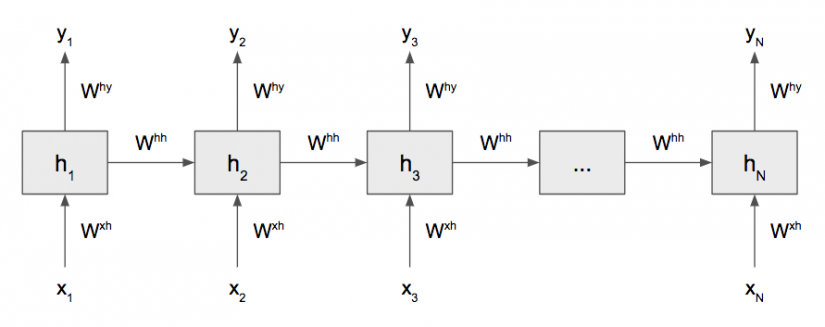

In [2]:
Image('rnn_unrolled.png')

The overall API of an RNN is as follows:

First, there is a standalone `RNN cell`, which takes an input `x` and a state `h`:

    def rnn_cell(x, h):
        y = f1(x, h)
        h = f2(x, h)
        
        return y, h

It produces an output `y` and an updated state `h`.  
This can now be used to define an `RNN`:

    def rnn(x_list):
        h_list = [initialize()]
        y_list = []
        
        for x in x_list:
            y, h = rnn_cell(x, h_list[-1])
            h_list.append(h)
            y_list.append(y)
        
        return y_list, h_list

The RNN reads an input sequence `x_list` and returns an output sequence `y_list` and the set of states, `h_list` for downstream tasks.

# Dealing with Text

Just like labels, we treat words as 1-hot vectors.  
For instance, if our vocabulary has three words, `the`, `an` and `apple`, we represent them as the basis vectors $(1, 0, 0)$, $(0, 1, 0)$ and $(0, 0, 1)$ of $\mathbb{R}^3$.

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000, )

In [4]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     maxlen=50,
                                                     padding='pre',
                                                     truncating='post')

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     maxlen=50,
                                                     padding='pre',
                                                     truncating='post')

In [5]:
word_to_idx = imdb.get_word_index()
idx_to_word = dict([(v, k) for k, v in word_to_idx.iteritems()])

In [6]:
sentence = x_train[0]
print ' '.join([idx_to_word[idx+2] for idx in sentence])

a for it's in want it is didn't holes told was with considered just little of from is you couldn't story cinema get more her given in of is american overall but with you but comic if in animated la i personally i write of was baby has water 10


In [7]:
# Inputs
inputs = tf.placeholder(tf.int32, shape=(None, 50))

In [8]:
# Embeddings
embeddings = tf.get_variable("embeddings", [5000, 20])
embed_inputs = tf.nn.embedding_lookup(embeddings, inputs)

In [9]:
# Take a look at the shape
print embed_inputs.shape

(?, 50, 20)


In [10]:
rnn_cell = tf.nn.rnn_cell.BasicRNNCell(50)

In [11]:
outputs, final_state = tf.nn.dynamic_rnn(rnn_cell,
                                         embed_inputs,
                                         dtype=tf.float32,
                                         time_major=False)

In [12]:
result = tf.keras.layers.Dense(1, activation='sigmoid')(final_state)

Targets and loss, optimization, etc.

In [13]:
target = tf.placeholder(tf.float32, shape=(None, 1), name='target')
loss = tf.reduce_mean(tf.square(target - result))

In [14]:
with tf.variable_scope('a'):
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)

Create a session

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
print x_train.shape
print x_test.shape

(25000, 50)
(25000, 50)


It's **training** time!

In [17]:
# For Adam's variables
sess.run(tf.global_variables_initializer())

for epoch in range(20):
    loss_history = []
    
    for i in range(250):
        _, l = sess.run((train_op, loss),
                        {inputs: x_train[i*100:(i+1)*100],
                         target: y_train[i*100:(i+1)*100].reshape((100, 1))})

        loss_history.append(l)
    
    if (epoch + 1) % 2 == 0:
        print 'Epoch:', epoch+1, 'Loss:', np.mean(loss_history)

Epoch: 2 Loss: 0.156441
Epoch: 4 Loss: 0.0957192
Epoch: 6 Loss: 0.060255
Epoch: 8 Loss: 0.0412882
Epoch: 10 Loss: 0.0342184
Epoch: 12 Loss: 0.0230766
Epoch: 14 Loss: 0.0152539
Epoch: 16 Loss: 0.0104575
Epoch: 18 Loss: 0.00893053
Epoch: 20 Loss: 0.00992821


Testing

In [18]:
accuracy = []

for i in range(100):
    pred = sess.run(tf.round(result), {inputs: x_train[i*100:(i+1)*100]})
    accuracy.append(np.mean(np.equal(pred.T, y_train[i*100:(i+1)*100])))

In [19]:
print 'Accuracy:', np.mean(accuracy)

Accuracy: 0.9835


# Sequence-to-sequence

Sequence to sequence is used for models requiring both a sequenced input and output, e.g. machine translation.

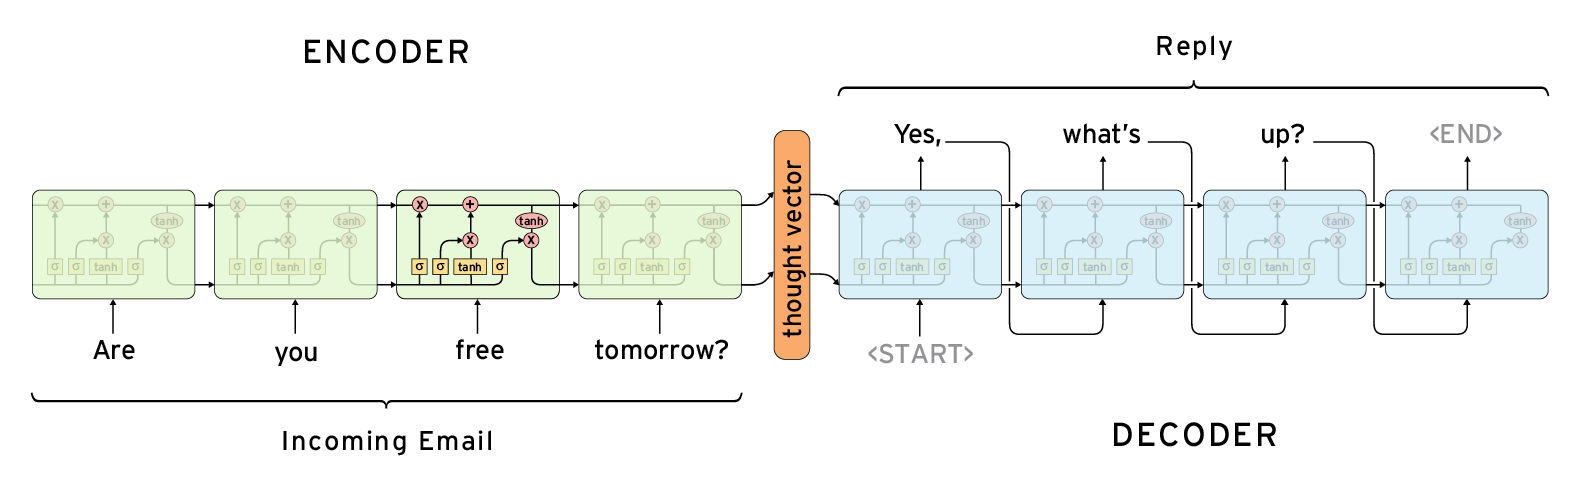

In [20]:
Image('seq2seq.png')

# Vanishing/Exploding Gradients, and LSTM/GRU

RNNs suffer from the problem of vanishing and exploding graidents.  
To solve exploding graidents, gradient clipping is used. (Look up if you see `NaN`s in your loss.)

To combat vanishing gradients, a variant of RNNs is used, called Long Short Term Memory or LSTM.  
Stated succintly, these cells maintain an additional long term `cell` in addition to the `hidden` vector, on which it performs careful updates:

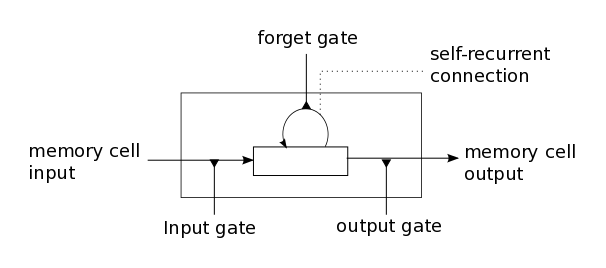

In [21]:
Image('lstm.png')

The GRU is a more computationally efficient variation of LSTMs.

Both these cells are available inside Tensorflow:

1. `tf.nn.rnn_cell.GRUCell`: Gated Recurrent Unit
2. `tf.nn.rnn_cell.BasicLSTMCell`: Long Short-Term Memory

# That's all, folks!

Any questions? Feel free to send me an e-mail (sohampal@iisc).